#Simulation for knockout training:
**Two-layer linear network, same bottleneck**


Idea:
Treat a ground truth model (two-layer linear network) as the fruit fly that we'll perturb.
We will generate control and silenced data from this ground truth model.

We will then train two models on this data:


*   KO network --- two-layer linear network trained with knockout
*   noKO network --- two-layer linear network trained *without* knockout

We will then evaluate the KO and noKO networks' abilities to recover the behavior of the silenced ground truth model as well as its internal activity.

Our prediction is that only the KO network should be able to recover both of these quantities.

This simulation follows that in Extended Data Figure 2a-c in our paper "Mapping model units to visual neurons reveals population code for social behaviour.", Cowley, B.R., Calhoun, A.J., Rangarajan, N., Ireland, E., Turner, M.H., Pillow, J.W. and Murthy, M., 2024. *Nature*, pp.1-9.


In [1]:
# import statements

import numpy as np
import tensorflow as tf

from keras import backend as K
from keras import utils
from keras.models import Model
from keras import layers

from keras.layers import Activation, BatchNormalization, Dense, Flatten, Input, Multiply
from keras.optimizers import Adam

import matplotlib.pyplot as plt

# Helper functions

In [2]:
### HELPER FUNCTIONS

def initialize_network(num_input_variables=48, num_hidden_units=8):
  # initializes a two-layer linear network that outputs a single variable
  #
  # INPUT:
  #  num_input_variables: (int), number of input feature variables (default=48)
  #  num_hidden units: (int), number of hidden units in middle layer (default=8)
  # OUTPUT:
  #  model: (Keras instance), outputs a Keras model

  x_input = Input(shape=(num_input_variables,), name='input')
  x_mask = Input(shape=(num_hidden_units,), name='mask')

  # define network  (input includes a 'mask' to inactivate or "knock out" certain hidden units)
  x = Dense(units=num_hidden_units, name='bottleneck')(x_input)
  x = Multiply()([x, x_mask])
  x = Dense(units=1, name='output')(x)

  model = Model(inputs=[x_input, x_mask], outputs=x)
  optimizer = Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  # Note: model takes as input a list of x_input and a mask of 1s and 0s
  return model


def generate_data(model, num_input_variables=48, num_hidden_units=8, num_samples=1000, iunit_inactivated=None):
  # generates data (input, hidden unit responses, and output) for a given model
  #     (can silence a particular hidden unit, which could potentially lead to different output)
  #
  # INPUT:
  #  model: (Keras instance), model of two-layer linear network (most likely the ground truth model)
  #  num_input_variables: (int), number of input feature variables for X (default=48)
  #  num_hidden_units: (int), number of hidden units in ground truth model (default=8)
  #  num_samples: (int), number of samples to generate (default=1000)
  #  iunit_inactivated: (0 to num_hidden_units-1, or 'None'), index of hidden unit to be inactivated
  #            if None or > num_hidden_units - 1, no units are inactivated
  #
  # OUTPUT:
  #	x_input: (num_samples, num_input_variables), generated input features
  #	responses_bottleneck: (num_samples, num_hidden_units), hidden unit responses to x_input
  #	y: (num_samples,), output behavior (with a small amount of added Gaussian noise)

  x_input = np.random.standard_normal(size=(num_samples, num_input_variables))
  mask_input = np.ones((num_samples,num_hidden_units))

  responses_bottleneck = get_hiddenunit_responses(model, x_input, num_hidden_units)
  # model_hiddenunits = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)
  # responses_bottleneck = model_hiddenunits.predict([x_input, mask_input], verbose=False)

  if iunit_inactivated != None and iunit_inactivated < num_hidden_units and iunit_inactivated >= 0:
    mask_input[:,iunit_inactivated] = 0.

  y = np.squeeze(model.predict([x_input, mask_input], verbose=False))
  y = y + 0.5 * np.random.standard_normal((y.shape)) # add Gaussian noise

  return x_input, responses_bottleneck, y


def get_hiddenunit_responses(model, x_input, num_hidden_units=8):
  # gets hidden unit responses from model to input features x_input
  #
  # INPUT:
  #  model: (Keras instance), model of two-layer linear network (most likely the ground truth model)
  #  x_input: (num_samples, num_input_variables), input features
  #  num_hidden_units: (int), number of hidden units in middle layer (default=8)
  #
  # OUTPUT:
  #  responses_bottleneck: (num_samples, num_hidden_units), hidden unit responses to x_input

  num_samples = x_input.shape[0]
  mask_input = np.ones((num_samples, num_hidden_units))
  model_hiddenunits = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)
  responses_bottleneck = model_hiddenunits.predict([x_input, mask_input], verbose=False)

  return responses_bottleneck


def compute_R2(y_test, y_hat, R2_type='cod'):
  # computes fraction of explained variance (R^2)
  #
  # INPUT:
  #	 y_test: (num_samples,), observed output (from ground truth model)
  #	 y_hat: (num_samples,), model predictions of observed output
  #	 R2_type: ('cod' or 'pearson'),
  #				-->coefficient of determination (R^2 can be negative); pearson-->rho^2 (always positive)
  # OUTPUT:
  #  R2: (float), prediction performance between y and y_hat

  if R2_type == 'cod':
    R2 = 1 - np.sum((y_hat - y_test)**2) / np.sum((y_test - np.mean(y_test))**2)
  else:
    R2 = np.corrcoef(y_test, y_hat)[0,1]**2

  return R2

# Generate data from ground truth model

Ground truth model: 48 input vars., 8 hidden units, 1 output unit

Training data:


*   input X ~ standard normal distribution
*   1k samples for control (no inactivation)
*   8 x 1k samples for inactivated hidden units (1k/hidden unit)

Test data:

Exact same as training data.





In [3]:
# Initialize ground truth model and generate training and test data

seed_index = 314159
utils.set_random_seed(seed_index)

## initialize ground truth network and generate data
num_input_variables = 48
num_hidden_units = 8
num_samples = 1000  # num samples per dataset

model_ground_truth = initialize_network(num_input_variables, num_hidden_units)

## generate training data
Xs_train = []  # datasets kept as lists, where Xs_train[i] corresponds
ys_train = []  #     to the ith hidden unit inactivated
               #     (and Xs_train[num_hidden_units+1] --> control)

for iunit in range(num_hidden_units+1):  # +1 for control
  X, _, y = generate_data(model_ground_truth, num_input_variables, num_hidden_units, iunit_inactivated=iunit)
  Xs_train.append(X)
  ys_train.append(y)

# generate test data
Xs_test = []
responses_test = []
ys_test = []

for iunit in range(num_hidden_units+1):
  X, responses_bottleneck, y = generate_data(model_ground_truth, num_input_variables, num_hidden_units, iunit_inactivated=iunit)
  Xs_test.append(X)
  responses_test.append(responses_bottleneck)
  ys_test.append(y)

# unit test: check sizes
print('Xs_train length =', end=' ')
print(len(Xs_train))
print('X_train shape: ', end=' ')
print(Xs_train[-1].shape)
print('ys_train length =', end=' ')
print(len(ys_train))
print('y_train shape: ', end=' ')
print(ys_train[-1].shape)
print('Xs_test length =', end=' ')
print(len(Xs_test))
print('X_test shape: ', end=' ')
print(Xs_test[-1].shape)
print('responses_test length =', end=' ')
print(len(responses_test))
print('responses_test shape: ', end=' ')
print(responses_test[-1].shape)
print('ys_test length =', end=' ')
print(len(ys_test))
print('y_test shape: ', end=' ')
print(ys_test[-1].shape)


Xs_train length = 9
X_train shape:  (1000, 48)
ys_train length = 9
y_train shape:  (1000,)
Xs_test length = 9
X_test shape:  (1000, 48)
responses_test length = 9
responses_test shape:  (1000, 8)
ys_test length = 9
y_test shape:  (1000,)


# Train KO network

Use knockout training to align the hidden units of a randomly-initialized two-layer linear network to those of the ground truth model.

In [4]:
## train KO model

K.clear_session()  # clears space (including ground truth model)
utils.set_random_seed(seed_index)
model_KO = initialize_network(num_input_variables, num_hidden_units)

num_epochs = 15
for iepoch in range(num_epochs): # number of passes through entire dataset
  for iunit in range(num_hidden_units+1): # +1 for control
    # create mask
    num_samples = Xs_train[iunit].shape[0]
    mask = np.ones((num_samples, num_hidden_units))
    if iunit < num_hidden_units:  # if not control
      mask[:,iunit] = 0.

    model_KO.fit([Xs_train[iunit], mask], ys_train[iunit], batch_size=64, verbose=False)

  # check perf on test set, control data and one silenced set
  mask = np.ones((num_samples, num_hidden_units))
  y_hat = np.squeeze(model_KO.predict([Xs_test[-1], mask], verbose=False))
  R2_control = compute_R2(ys_test[-1], y_hat, R2_type='cod')

  mask[:,0] = 0.
  y_hat = np.squeeze(model_KO.predict([Xs_test[0], mask], verbose=False))
  R2_unit0 = compute_R2(ys_test[0], y_hat, R2_type='cod')
  print('epoch {:d}, R2 control = {:f}, R2 unit0 = {:f}'.format(iepoch, R2_control, R2_unit0))


epoch 0, R2 control = 0.918687, R2 unit0 = 0.877536
epoch 1, R2 control = 0.915092, R2 unit0 = 0.865875
epoch 2, R2 control = 0.916752, R2 unit0 = 0.882117
epoch 3, R2 control = 0.915994, R2 unit0 = 0.889610
epoch 4, R2 control = 0.917938, R2 unit0 = 0.893830
epoch 5, R2 control = 0.917519, R2 unit0 = 0.892894
epoch 6, R2 control = 0.917133, R2 unit0 = 0.893012
epoch 7, R2 control = 0.918825, R2 unit0 = 0.894734
epoch 8, R2 control = 0.921098, R2 unit0 = 0.896500
epoch 9, R2 control = 0.922578, R2 unit0 = 0.897258
epoch 10, R2 control = 0.922640, R2 unit0 = 0.897439
epoch 11, R2 control = 0.921735, R2 unit0 = 0.897480
epoch 12, R2 control = 0.920478, R2 unit0 = 0.897860
epoch 13, R2 control = 0.919575, R2 unit0 = 0.899168
epoch 14, R2 control = 0.919823, R2 unit0 = 0.899714


# Evaluate KO network on behavior + response prediction

Given the trained KO network, evaluate how well it predicts
output behavior (including silenced sessions)
as well as the responses of hidden unit activity of the
ground truth model.


In [5]:
## behavior prediction performance for KO network
R2s_behavior_KO = []
for iunit in range(num_hidden_units+1):
  num_samples = Xs_test[iunit].shape[0]
  mask = np.ones((num_samples, num_hidden_units))
  if iunit < num_hidden_units:  # hidden unit was silenced (not control)
    mask[:,iunit] = 0.

  y_hat = np.squeeze(model_KO.predict([Xs_test[iunit], mask], verbose=False))
  R2 = compute_R2(ys_test[iunit], y_hat, R2_type='cod')
    # we use coefficient of determination "cod" here to account for
    #  differences in overall mean, std. dev., and sign

  if iunit < num_hidden_units:
    print('behavior prediction, unit {:d}, behavior R2 = {:f}'.format(iunit, R2))
  else:
    print('behavior prediction, control, behavior R2 = {:f}'.format(R2))
    # (we will plot these later)

  R2s_behavior_KO.append(R2)


## neural prediction performance for KO network
# (tested on control data --- e.g., recording activity of control animal)
R2s_neural_KO = []
for iunit in range(num_hidden_units):
  responses_model = get_hiddenunit_responses(model_KO, Xs_test[-1], num_hidden_units)

  R2 = compute_R2(responses_test[-1][:,iunit], responses_model[:,iunit], R2_type='pearson')
    # we use pearson correlation**2 here to ignore differences
    #  in overall mean, std. dev., and sign, as we are not interested
    #  in predicting, e.g., average firing rates but rather the information content

  print('unit {:d}, neural R2 = {:f}'.format(iunit, R2))
  R2s_neural_KO.append(R2)


behavior prediction, unit 0, behavior R2 = 0.899714
behavior prediction, unit 1, behavior R2 = 0.902678
behavior prediction, unit 2, behavior R2 = 0.907457
behavior prediction, unit 3, behavior R2 = 0.889709
behavior prediction, unit 4, behavior R2 = 0.888016
behavior prediction, unit 5, behavior R2 = 0.918353
behavior prediction, unit 6, behavior R2 = 0.914779
behavior prediction, unit 7, behavior R2 = 0.868147
behavior prediction, control, behavior R2 = 0.919823
unit 0, neural R2 = 0.932000
unit 1, neural R2 = 0.812542
unit 2, neural R2 = 0.773541
unit 3, neural R2 = 0.907699
unit 4, neural R2 = 0.940937
unit 5, neural R2 = 0.007167
unit 6, neural R2 = 0.399627
unit 7, neural R2 = 0.894905


# Train noKO network

Train a two-layer linear network in the exact same was as the KO network
except *without* knockout training. This is the no-knockout (noKO) network.

The noKO network represents the null hypothesis that no change in behavior occurs between silencing/inactivating hidden units of the ground truth model and control data. For hidden units that do *not* contribute to behavior, we would expect the noKO network to predict behavior better than or on par with the KO network for sessions in which these hidden units have been inactivated.

The noKO network provides an important *relative* comparison for knockout training.  In our paper, we also explore a network with dropout training (in which hidden units are randomly inactivated during training)---this is a regularization technique to prevent overfitting and can also be considered an important relative comparison for the KO network.

In [6]:
## train noKO model

K.clear_session()  # clears space (including ground truth model)
utils.set_random_seed(seed_index)
model_noKO = initialize_network(num_input_variables, num_hidden_units)

num_epochs = 15
for iepoch in range(num_epochs): # number of passes through entire dataset
  for iunit in range(num_hidden_units+1): # +1 for control
    # create mask
    num_samples = Xs_train[iunit].shape[0]
    mask = np.ones((num_samples, num_hidden_units)) # all ones -- no masking

    model_noKO.fit([Xs_train[iunit], mask], ys_train[iunit], batch_size=64, verbose=False)

  # check perf on test set, control data and one silenced set
  mask = np.ones((num_samples, num_hidden_units))
  y_hat = np.squeeze(model_noKO.predict([Xs_test[-1], mask], verbose=False))
  R2_control = compute_R2(ys_test[-1], y_hat, R2_type='cod')

  y_hat = np.squeeze(model_noKO.predict([Xs_test[0], mask], verbose=False))
  R2_unit0 = compute_R2(ys_test[0], y_hat, R2_type='cod')
  print('epoch {:d}, R2 control = {:f}, R2 unit0 = {:f}'.format(iepoch, R2_control, R2_unit0))

epoch 0, R2 control = 0.879458, R2 unit0 = 0.486976
epoch 1, R2 control = 0.892047, R2 unit0 = 0.448017
epoch 2, R2 control = 0.891576, R2 unit0 = 0.383149
epoch 3, R2 control = 0.880737, R2 unit0 = 0.361716
epoch 4, R2 control = 0.877788, R2 unit0 = 0.364564
epoch 5, R2 control = 0.881994, R2 unit0 = 0.325933
epoch 6, R2 control = 0.885763, R2 unit0 = 0.356546
epoch 7, R2 control = 0.892750, R2 unit0 = 0.357778
epoch 8, R2 control = 0.887602, R2 unit0 = 0.330237
epoch 9, R2 control = 0.894646, R2 unit0 = 0.354952
epoch 10, R2 control = 0.885627, R2 unit0 = 0.352474
epoch 11, R2 control = 0.889935, R2 unit0 = 0.361838
epoch 12, R2 control = 0.894086, R2 unit0 = 0.354927
epoch 13, R2 control = 0.894457, R2 unit0 = 0.337628
epoch 14, R2 control = 0.891221, R2 unit0 = 0.344395


# Evaluate noKO network on behavior + response prediction

Given the trained noKO network, evaluate how well it predicts
output behavior (including silenced sessions)
as well as the responses of hidden unit activity of the
ground truth model.

Note: To predict output behavior of models with inactivated hidden units,
we still do not inactivate any hidden unit of the noKO network, keeping
training and test contexts the same. The noKO network assumes no hidden
unit has been inactivated.

In [7]:
## behavior prediction performance for noKO network
R2s_behavior_noKO = []
for iunit in range(num_hidden_units+1):
  num_samples = Xs_test[iunit].shape[0]
  mask = np.ones((num_samples, num_hidden_units))
  y_hat = np.squeeze(model_noKO.predict([Xs_test[iunit], mask], verbose=False))

  R2 = compute_R2(ys_test[iunit], y_hat, R2_type='cod')

  if iunit < num_hidden_units:
    print('behavior prediction, unit {:d}, behavior R2 = {:f}'.format(iunit, R2))
  else:
    print('behavior prediction, control, behavior R2 = {:f}'.format(R2))
    # (we will plot these later)

  R2s_behavior_noKO.append(R2)


## neural prediction performance for noKO network
# (tested on control data --- e.g., recording activity of control animal)
R2s_neural_noKO = []
for iunit in range(num_hidden_units):
  responses_model = get_hiddenunit_responses(model_noKO, Xs_test[-1], num_hidden_units)

  R2 = compute_R2(responses_test[-1][:,iunit], responses_model[:,iunit], R2_type='pearson')

  print('unit {:d}, neural R2 = {:f}'.format(iunit, R2))
  R2s_neural_noKO.append(R2)

behavior prediction, unit 0, behavior R2 = 0.344395
behavior prediction, unit 1, behavior R2 = 0.722290
behavior prediction, unit 2, behavior R2 = 0.846015
behavior prediction, unit 3, behavior R2 = 0.604766
behavior prediction, unit 4, behavior R2 = 0.401430
behavior prediction, unit 5, behavior R2 = 0.890041
behavior prediction, unit 6, behavior R2 = 0.870887
behavior prediction, unit 7, behavior R2 = 0.742711
behavior prediction, control, behavior R2 = 0.891221
unit 0, neural R2 = 0.334096
unit 1, neural R2 = 0.000779
unit 2, neural R2 = 0.006717
unit 3, neural R2 = 0.017309
unit 4, neural R2 = 0.242629
unit 5, neural R2 = 0.038958
unit 6, neural R2 = 0.000063
unit 7, neural R2 = 0.060546


# Plot results

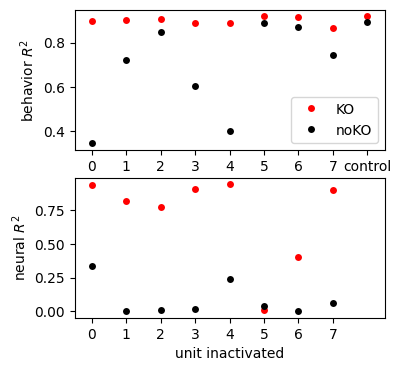

In [8]:
## plot R2 results
f = plt.figure(figsize=(4,4))

# R2s behavior
plt.subplot(2,1,1)
plt.plot(R2s_behavior_KO, '.r', mew=0., ms=10, label='KO')
plt.plot(R2s_behavior_noKO, '.k', mew=0., ms=10, label='noKO')
plt.xlabel('unit inactivated')
plt.ylabel('behavior $R^2$')
plt.xlim([-0.5,8.5])
plt.xticks(np.arange(9), labels=[i for i in range(8)] + ['control'])

plt.legend()

# R2s neural
plt.subplot(2,1,2)
plt.plot(R2s_neural_KO, '.r', mew=0., ms=10)
plt.plot(R2s_neural_noKO, '.k', mew=0., ms=10)
plt.xlabel('unit inactivated')
plt.ylabel('neural $R^2$')
plt.xlim([-0.5,8.5])  # include control spot so it matches with R2s_behavior
plt.xticks(np.arange(8), labels=np.arange(8))

f.show()


**Top plot:** Behavior $R^2$ versus the index of the hidden unit inactivated in the ground truth model. The KO network (red dots) beter predicts behavior of the inactivated units versus the noKO network (black dots). For control data, both the KO and noKO networks perform similarly ('control', black and red dots overlap).

**Bottom plot:** Neural $R^2$ versus the index of the hidden unit inactivated in the ground truth model. The KO network is able to recover the responses of the hidden units versus the noKO network (red dots above black dots). For units 5 and 6, the red and black dots are closer together. These hidden units likely contribute little to behavior (making it difficult for knockout training to predict their responses)---indeed, the KO and noKO networks predict the behavior of these inactivated units about the same (top plot, units 5 and 6, red and black dots overlap).

Thus, only the KO network successfully recovered the unit-perturbed behavior and responses of the hidden units.